# Measuring grain size using the linear intercept method

In the image analysis session, we used labelling and other `skimage` functions to measure the size of particles. However, this method isn't very useful to measure the grain size in metals, where the only feature visible in the image is the grain boundaries. 

There are a number of standard methods for measuring grain size, but one of the most widely used ones is the mean linear intercept method. You will have come across it in the "Microstructures of Materials" module, taught by Dr Phil Frankel. Here is a slide to jog your memory.

![Slide from lecture notes](https://dl.dropboxusercontent.com/s/4z63vq80i29wms1/Linear_intercept.png)

In this notebook, you can see how Python can be used to implement this method for measuring grain size. The notebook takes through a possible image analysis workflow that can be used to measure grain size. This workflow makes extensive use of ready-made functions in the `skimage` package. At the end of the notebook, the workflow is brought together into two functions that can be easily reused. 

We start off by importing the usual modules:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In addition, we need to import some modules and functions from `skimage`. Their usefulness will become apparent as we work through the notebook.

In [2]:
from skimage import io
from skimage.morphology import remove_small_objects,skeletonize,closing,disk,square,dilation
from skimage.filters import sobel,threshold_otsu
from skimage.color import rgb2gray

## Getting a good grain boundary image

First we read in the image. The file loaded below can be downloaded from [here](https://dl.dropboxusercontent.com/u/1296308/steel_sample.png).

In [4]:
image=io.imread('steel_sample.png')

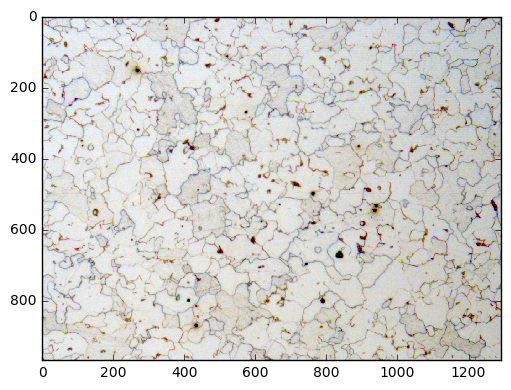

In [5]:
io.imshow(image)

This is a colour image, which we can check by looking at the shape of the `image` array:

In [6]:
print(np.shape(image))

(968, 1292, 3)


This tells us the image is 968 pixels high, 1292 pixels wide and has 3 intensity channels, which correspond to **R**ed, **G**reen and **B**lue (RGB). In order to work with this image, we first need to flatten it into a greyscale image using the rgb2gray function:

In [7]:
gray_image=rgb2gray(image)

This has converted the array into a simple 2D array:

In [8]:
np.shape(gray_image)

(968, 1292)

The image is now in greyscale:

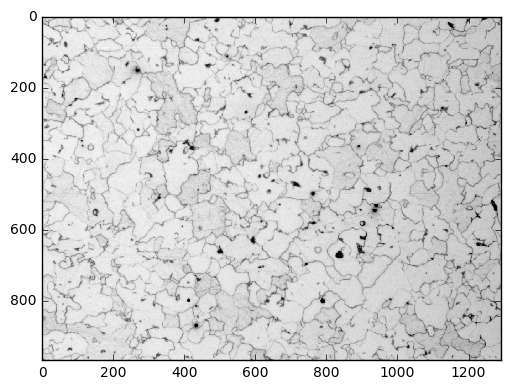

In [9]:
io.imshow(gray_image)

In the linear intercept method, we want to determine the number of interceptions with grain boundaries and regularly spaced lines. The first step is to get a good image of the grain boundaries. We could use thresholding to do this, but because the intensity of the image changes throughout (different grains have different intensities because of the orientation) this can be tricky. Instead we will use a filter to detect edges: the [sobel filter](https://en.wikipedia.org/wiki/Sobel_operator). 

In [10]:
edge_image=sobel(gray_image)

This produces a map of the instensity gradient of the image:

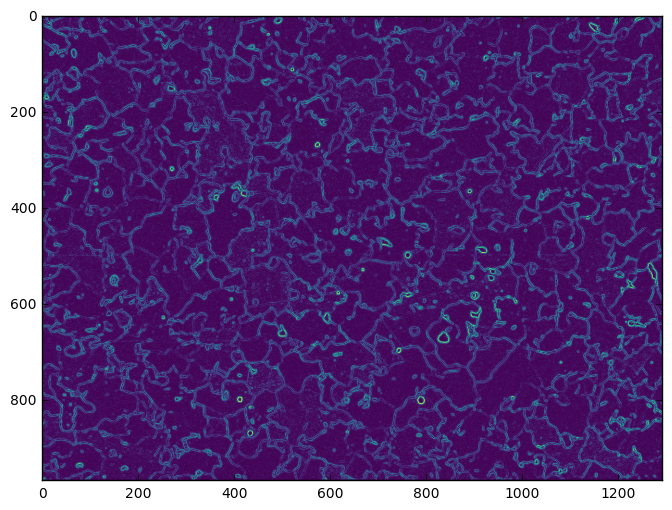

In [11]:
plt.figure(figsize=(8,6))
plt.imshow(edge_image, cmap='viridis')

This is a good start but since we will be after interceptions we need to convert this into an image where the grain boundaries are one pixel thin. To do this we will first threshold to get a representative binary image. First we plot a histogram to see what the distribution of gradients looks like:

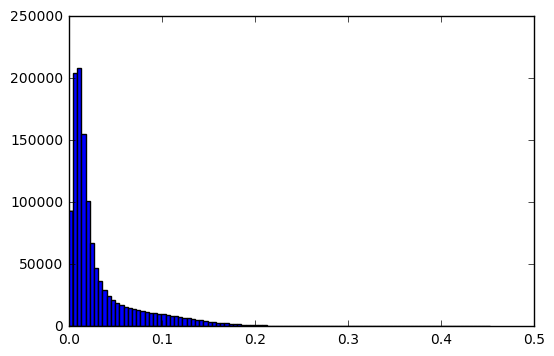

In [12]:
plt.hist(edge_image.flatten(),bins=100);

We can see there is a peak below 0.005 and almost all the values are less than 0.2. To get a good starting point for a threshold value, we can use Otsu's method:

In [13]:
thresh=threshold_otsu(edge_image)
print(thresh)

0.0680416491445


Which we can then test:

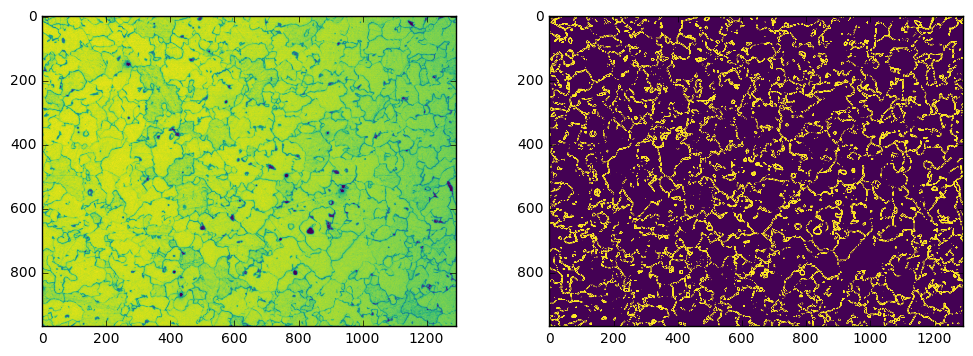

In [14]:
thresh_edge=edge_image>0.068
fig1,ax1=plt.subplots(1,2, figsize=(12,4))
ax1[0].imshow(gray_image,cmap='viridis')
ax1[1].imshow(thresh_edge, cmap='viridis');

This is pretty good, but we should keep in mind that it _might require adjustment for different images_.

Another problem is that, because the grain boundaries are not one pixel thin, the each have two edges. This can be seen clearly if we plot a small 200 pixel wide region:

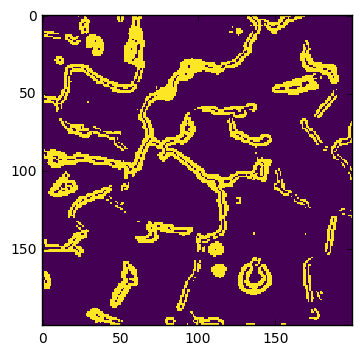

In [20]:
plt.imshow(thresh_edge[200:400,:200], cmap='viridis',interpolation='nearest')

To convert the two edges into one boundary, we carry out a [`closing` operation](http://scikit-image.org/docs/dev/auto_examples/applications/plot_morphology.html#closing), which closes off any holes in the binary image. The closing function requires an approximate shape of the wholes it needs to fill. These can be generated with the functions `disk` or `square`. To make a disk with a 3 pixel radius:

In [16]:
shape=disk(3)

We can then use this shape with the `closing` function:

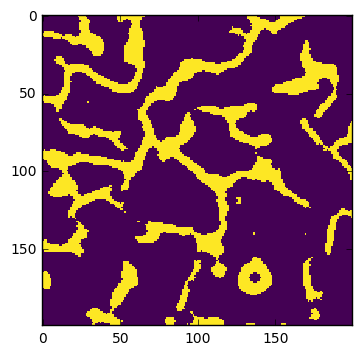

In [19]:
closed_edge=closing(thresh_edge,shape)
plt.imshow(closed_edge[200:400,:200], cmap='viridis',interpolation='nearest')

Which seems to do a good job. 

The other issue we have is that our image is full of pits, particles and other small objects we would ignore if doing the method manually, but would look like grain boundaries to an algorithm. To do this, we need to remove the small objects:

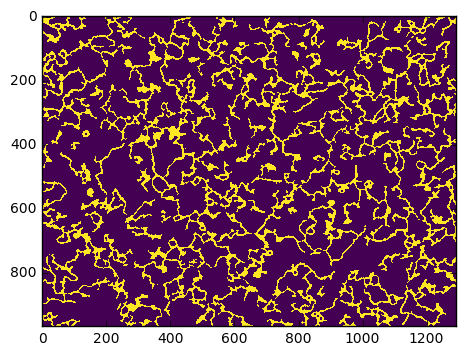

In [21]:
clean_edge=remove_small_objects(closed_edge,min_size=300)
plt.imshow(clean_edge, cmap='viridis',interpolation='nearest')

This is not perfect, but it's pretty good. We could probably do better, but for now we carry on with this result.. 

Because we are interested in intercepts, we would like the boundaries to be one pixel thin. There is a function for that, called `skeletonize`:

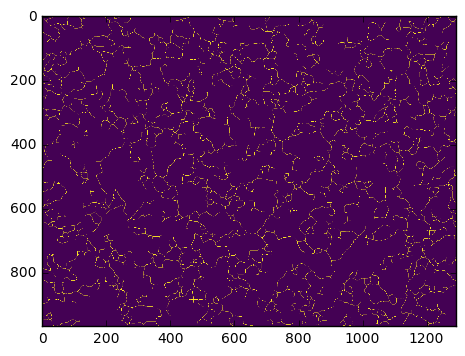

In [30]:
thin_boundaries=skeletonize(clean_edge)
plt.imshow(thin_boundaries, cmap='viridis')

We should check this still looks like our image:

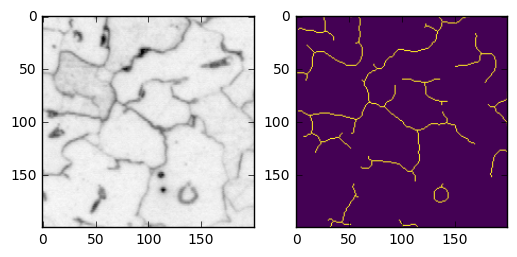

In [31]:
fig1,ax1=plt.subplots(1,2)
ax1[0].imshow(gray_image[200:400,:200],cmap='gray')
ax1[1].imshow(thin_boundaries[200:400,:200], cmap='viridis');

This is pretty good although we can certainly get better by adjusting the threshold value we used. For now, though we will use this grain boundary image to find our intercepts.

## Counting intercepts

We are going to use both horizontal and vertical lines to get our intercepts. This is straight forward since these are just rows and columns of the image array. The spacing between the lines will be called the step_size. We can plot the lines using `axvline` and `axhline`:

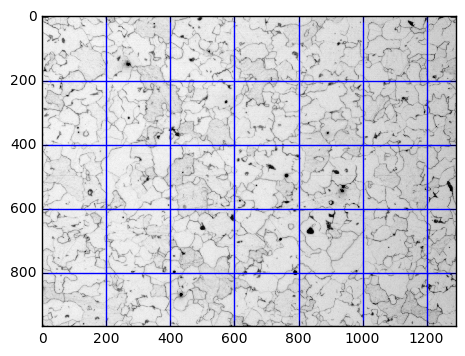

In [32]:
plt.imshow(gray_image,cmap='gray')
step_size=200
rows=range(step_size,np.shape(image)[0],step_size) # the rows for the stepsize above
cols=range(step_size,np.shape(image)[1],step_size) # the columns for the stepsize above

#plot all rows and columns
for row in rows:
    plt.axhline(row,color='b')
for col in cols:
    plt.axvline(col,color='b')

Since we have created an image of pixel-wide grain boundaries, finding intercepts is relatively easy. We just loop through the rows and columns and find out where in each there is a value of '1':

In [156]:
#loop through the rows
row_intercepts_list=[]
for row in rows:
    line=thin_boundaries[row,:]
    row_intercepts=np.where(line==1)[0] #find where there is a grain boundary
    row_intercepts_list.append(row_intercepts)

#loop through the columns
col_intercepts_list=[]
for col in cols:
    line=thin_boundaries[:,col]
    col_intercepts=np.where(line==1)[0]#find where there is a grain boundary
    col_intercepts_list.append(col_intercepts)

We now have lists of all the row and columns intercepts, for a step size of 200. We should check these are correct by plotting them:

(0, 968)

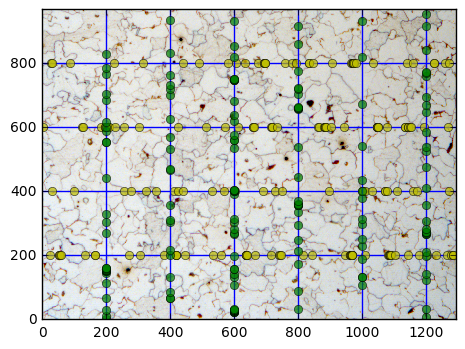

In [157]:
plt.imshow(image,cmap='gray')

for row,points in zip(rows, row_intercepts_list):
    plt.axhline(row,color='b')
    yvals=np.ones(np.shape(points))*row
    xvals=points
    plt.plot(xvals,yvals,'yo',alpha=0.7)
    
for col,points in zip(cols,col_intercepts_list):
    plt.axvline(col,color='b')
    xvals=np.ones(np.shape(points))*col
    yvals=points
    plt.plot(xvals,yvals,'go',alpha=0.7)
    
plt.xlim(0,np.shape(image)[1])
plt.ylim(0,np.shape(image)[0])

It seems that this works pretty well. However, there are some regions where there seem to be far too many intercepts, very close together. For example:

(950, 975)

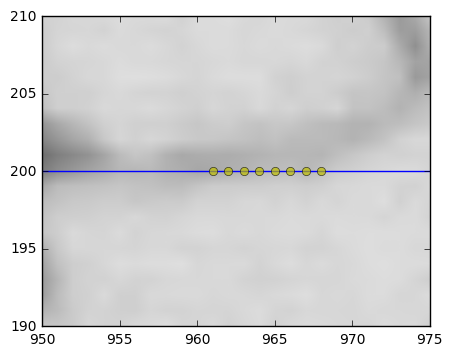

In [158]:
plt.imshow(gray_image,cmap='gray')
for row,points in zip(rows, row_intercepts_list):
    plt.axhline(row,color='b')
    yvals=np.ones(np.shape(points))*row
    xvals=points
    plt.plot(xvals,yvals,'yo',alpha=0.7)   
for col,points in zip(cols,col_intercepts_list):
    plt.axvline(col,color='b')
    xvals=np.ones(np.shape(points))*col
    yvals=points
    plt.plot(xvals,yvals,'go',alpha=0.7)
    
plt.ylim(190,210)
plt.xlim(950,975)

This is an artefact, as can be seen by plotting the boundary image:

(950, 975)

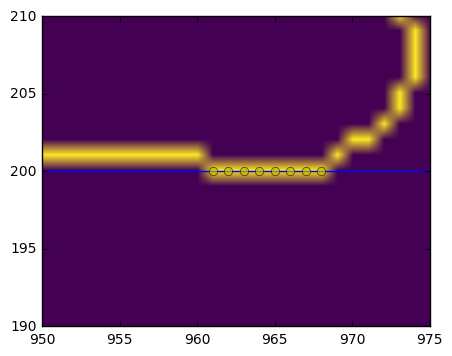

In [46]:
plt.imshow(thin_boundaries,cmap='viridis')
for row,points in zip(rows, row_intercepts_list):
    plt.axhline(row,color='b')
    yvals=np.ones(np.shape(points))*row
    xvals=points
    plt.plot(xvals,yvals,'yo',alpha=0.7)   
for col,points in zip(cols,col_intercepts_list):
    plt.axvline(col,color='b')
    xvals=np.ones(np.shape(points))*col
    yvals=points
    plt.plot(xvals,yvals,'go',alpha=0.7)
    
plt.ylim(190,210)
plt.xlim(950,975)

To remove these artifacts we filter the intercepts by their distance. The distances between the intercepts can determined by the difference in their values, using `ediff1d`:

In [159]:
row_distances_list=[]
for row_intercepts in row_intercepts_list:
    row_distances=np.ediff1d(row_intercepts,to_end=step_size)
    row_distances_list.append(row_distances)
col_distances_list=[]
for col_intercepts in col_intercepts_list:
    col_distances=np.ediff1d(col_intercepts,to_end=step_size)
    col_distances_list.append(col_distances)

The row we are interested in is the first row. If we print the distances in it:

In [160]:
print(row_distances_list[0])

[ 29   1   1   4  74  31   1 105  35  75  37   1   1  27  86  27  76   1
   1   1   1  24  51  24   6   1  68  31 103  14   1   1   1   1   1   1
   1  41  72   2   1   1   1   1   1  13  42  34  25  27  35  14   4   1
 200]


we can see that there are a number of points that are only one pixel apart. These must be filtered out. In the next cell we filter and plot at the same time:

(950, 975)

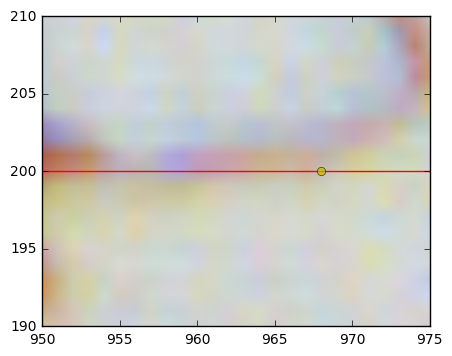

In [161]:
plt.imshow(image,cmap='gray',origin='bottom')
 
for row,points,distances in zip(rows,row_intercepts_list,row_distances_list):
    plt.axhline(row,color='r')
    points=points[np.where(distances>1)[0]]
    yvals=np.ones(np.shape(points))*row
    xvals=points
    plt.plot(xvals,yvals,'yo',alpha=0.7)
    
for col,points,distances in zip(cols,col_intercepts_list,col_distances_list):
    plt.axvline(col,color='r')
    points=points[np.where(distances>1)[0]]
    xvals=np.ones(np.shape(points))*col
    yvals=points
    plt.plot(xvals,yvals,'bo',alpha=0.7)
    
plt.ylim(190,210)
plt.xlim(950,975)

As you can see the filtering removes adjoining points. We will probably need to chose the threshold and this minimum distance parameter carefully. We will return to this later.

To measure grain size, all we need now is to count the number of intercepts and divide the length of each row/column by that number:

$$ \text{Grain size} = \dfrac{\text{length of line}}{\text{number of intercepts}}$$

In [162]:
count_row_list=[]
count_col_list=[]

#count number of points in each row and column
for row,points,distances in zip(rows,row_intercepts_list,row_distances_list):
    points=np.size(points[np.where(distances>1)[0]])
    count_row_list.append(points)
for col,points,distances in zip(cols,col_intercepts_list,col_distances_list):
    points=np.size(points[np.where(distances>1)[0]])
    count_col_list.append(points)

# Divide length of lines by counts
x_dist=np.shape(gray_image)[1]/np.mean(count_row_list)
y_dist=np.shape(gray_image)[0]/np.mean(count_col_list)

In [163]:
print(x_dist)
print(y_dist)
print(np.mean([x_dist,y_dist]))

46.1428571429
50.0689655172
48.10591133


These numbers are in units of pixels, and the final step is to convert them into SI units using a calibrated image. But we leave that as an exercise for you.

What we will do instead is collate the steps above into 2 functions that can be rapidly reused.

## Functions

Here we collect all the steps above to define 2 functions: one that produces the pixel thin grain boundary image and another that measures grain size.

In [3]:
def get_boundaries(fname, thresh_offset=0.04, small_objects=250, show_figure=True ):
    '''Uses edge filtering and thresholding to give clean grain boundaries
    
    Keywords:
    thresh_offset -- threshold offset
    small_objects -- size of window used to remove small objects in pixels
    figure -- show the thresholded and original image
    '''
    
    # read image in and threshold
    image=io.imread(fname)
    image=rgb2gray(image)
    edge=sobel(image)
    edge=edge>thresh_offset
    edge=closing(edge,disk(3))
    edge=remove_small_objects(edge,min_size=small_objects)
    thin_boundaries=skeletonize(edge)
    
    if (show_figure):
        # compare original and thresholded
        f,ax=plt.subplots(1,2,figsize=(16,9))
        ax[0].imshow(image,cmap='gray',origin='bottom')
        # we use dilation here for visualization purposes only
        ax[1].imshow(dilation(thin_boundaries,square(3)),cmap='gray',origin='bottom') 
    
    return thin_boundaries

In [10]:
def measure_grain(edge_image, step_size=100, min_distance=0, image_file=None):
    ''' Measure grain size by the linear intercept method. 
    Inputs:
    thresh_image -- binary image of grain boundaries (from thresh_and_clean)

    Keywords:
    step_size -- distance in pixels between intercept lines
    min_distance -- minimum distance allowed between intercepts in pixels
    image_file -- filename of image to be used to display intercepts
    '''
        
    #find intercepts and distances
    rows=range(step_size,np.shape(edge_image)[0],step_size) # the rows 
    cols=range(step_size,np.shape(edge_image)[1],step_size) # the columns 

    row_intercepts_list=[]
    col_intercepts_list=[]
    row_counts_list=[]
    col_counts_list=[]
    
    for row in rows:
        line=edge_image[row,:]
        row_intercepts=np.where(line==1)[0]
        row_distances=np.ediff1d(row_intercepts,to_end=step_size)
        row_intercepts_filtered=row_intercepts[np.where(row_distances>min_distance)[0]]
        row_counts=np.size(row_intercepts_filtered)
        row_intercepts_list.append(row_intercepts_filtered)
        row_counts_list.append(row_counts)
        
    for col in cols:
        line=edge_image[:,col]
        col_intercepts=np.where(line==1)[0]
        col_distances=np.ediff1d(col_intercepts,to_end=step_size)
        col_intercepts_filtered=col_intercepts[np.where(col_distances>min_distance)[0]]
        col_counts=np.size(col_intercepts_filtered)
        col_intercepts_list.append(col_intercepts_filtered)
        col_counts_list.append(col_counts)
    
    
    #calculate mean distances
    x_size=np.shape(edge_image)[1]/np.mean(col_counts_list)
    y_size=np.shape(edge_image)[0]/np.mean(col_counts_list)

    #plot image and measured intercepts
    if (image_file):
        
        original_image=io.imread(image_file)
        io.imshow(original_image)

        for row,points in zip(rows,row_intercepts_list):
            plt.axhline(row,color='y')
            yvals=np.ones(np.shape(points))*row
            plt.plot(points,yvals,'go',alpha=0.7)

        for col,points in zip(cols,col_intercepts_list):
            plt.axvline(col,color='y')
            xvals=np.ones(np.shape(points))*col
            plt.plot(xvals,points,'bo',alpha=0.7)

        plt.xlim(0,np.shape(edge_image)[1])
        plt.ylim(0,np.shape(edge_image)[0])

        print('X distance from intercepts: {:2.2f} pixels'.format(x_size))
        print('Y distance from intercepts: {:2.2f} pixels'.format(y_size))

    return [x_size,y_size]

# Testing the functions

We can now call the functions and do the analysis in one step:

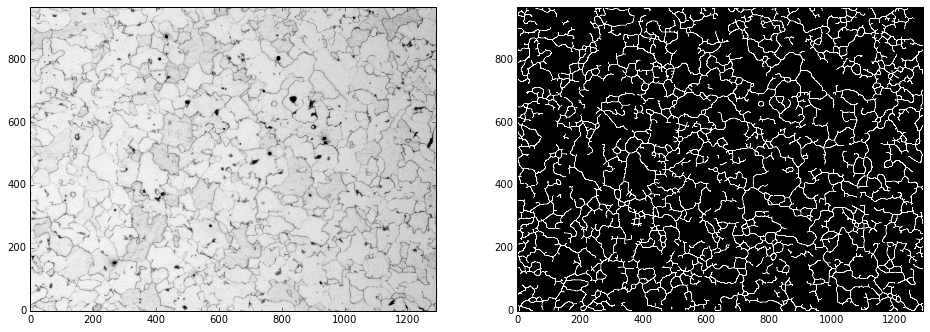

In [8]:
edge_image=get_boundaries('steel_sample.png',thresh_offset=0.05,small_objects=200)

X distance from intercepts: 53.65 pixels
Y distance from intercepts: 40.19 pixels


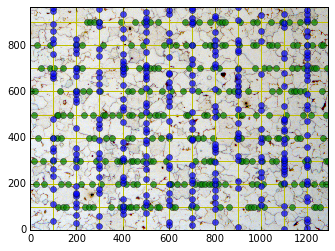

In [11]:
distances=measure_grain(edge_image, step_size=100, min_distance=4,image_file='steel_sample.png')

The mean value is:

In [12]:
print('Mean grain size = {:2.2f} pixels.'.format(np.mean(distances)))

Mean grain size = 46.92 pixels.


These functions can also be run silently. This is very useful if you want to run several images or test the effect of some of the optional parameters. For example, let's try a few different thresholds and minimum distances:

In [13]:
thresholds_list=np.linspace(0.01,0.07,28)
min_distances_list=[1,5,10,20,30]
min_dist_list=[]
for dist in min_distances_list:
    distances_list=[]
    for thresh in thresholds_list:
        edge_image=get_boundaries('steel_sample.png',thresh_offset=thresh, 
                                  small_objects=200, show_figure=False)
        distances=measure_grain(edge_image, step_size=100, min_distance=dist)
        distances_list.append(np.mean(distances))
    min_dist_list.append(distances_list)

/Users/mbcx9ma4/anaconda/lib/python2.7/site-packages/skimage/morphology/misc.py:119: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warnings.warn("Only one label was provided to `remove_small_objects`. "


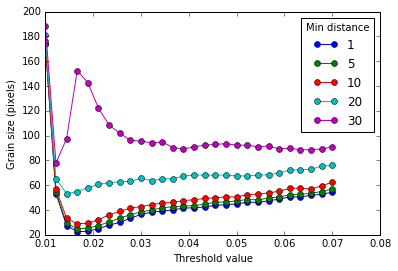

In [14]:
for dist in min_dist_list:
    plt.plot(thresholds_list,dist,'-o')
plt.legend(min_distances_list, title='Min distance')
plt.ylabel('Grain size (pixels)')
plt.xlabel('Threshold value')

From this we seen that the distance parameter can be very important and that something happens at threshold values below 0.02. We can investigate further. Here is what happens at 0.015:

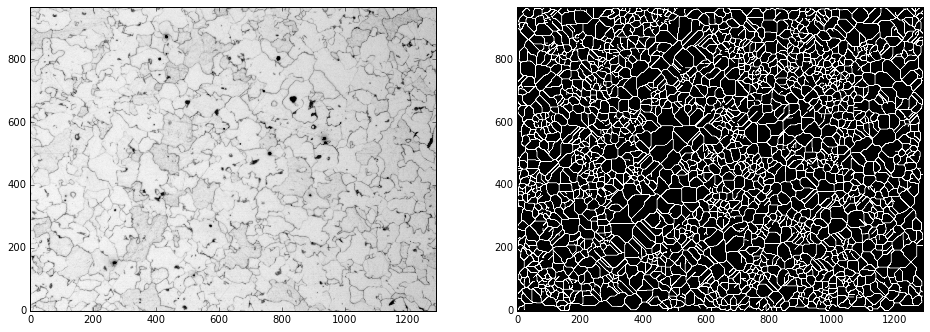

In [15]:
edge_image=get_boundaries('steel_sample.png',thresh_offset=0.015,small_objects=200)

Clearly our algorithm creates boundaries that aren't there. Which disappear at larger offsets:

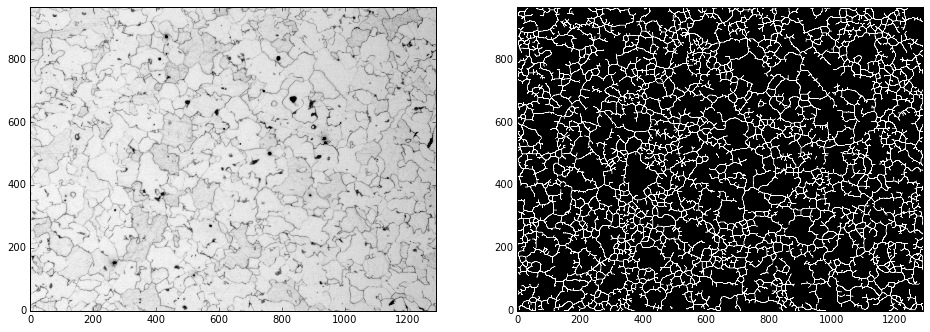

In [16]:
edge_image=get_boundaries('steel_sample.png',thresh_offset=0.03,small_objects=200)

Of course the best way to check parameters is by inspection. We can plot the intercepts and see if we are happy:

X distance from intercepts: 47.56 pixels
Y distance from intercepts: 35.63 pixels


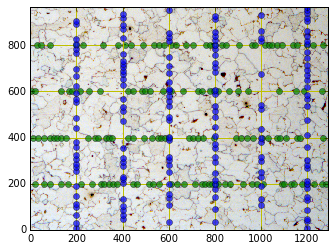

In [17]:
distances=measure_grain(edge_image, step_size=200, min_distance=10,image_file='steel_sample.png')

X distance from intercepts: 110.74 pixels
Y distance from intercepts: 82.97 pixels


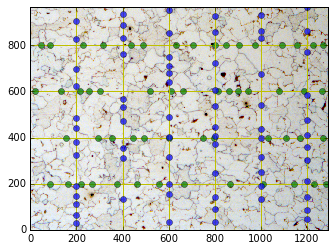

In [18]:
distances=measure_grain(edge_image, step_size=200, min_distance=30,image_file='steel_sample.png')

From these it is clear that at `min_distance = 30`, many grain boundaries are missed. 

In the end it is still somewhat subjective, and different people will chose different offsets/distances. The same is true of doing this manually. However, this calculation is now reproducible, unlike counting intercepts on a print-out. And much faster!

From this analysis, a good choice would be a threshold of 0.035  and a distance of 5. This gives us a grain size of:

In [19]:
edge_image=get_boundaries('steel_sample.png',thresh_offset=0.035,small_objects=200,show_figure=False)
distances=measure_grain(edge_image, step_size=100, min_distance=5)
print('Mean grain size = {:2.2f} pixels.'.format(np.mean(distances)))

Mean grain size = 41.60 pixels.
